In [1]:
import numpy as np
import h5py
import time
import json
import torch
from tqdm import tqdm
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms.v2 as transforms
import torchvision.models as models
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    roc_auc_score,
    average_precision_score,
)

torch.manual_seed(42)
torch.cuda.manual_seed(42)
np.random.seed(42)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [2]:
x_train_path = "/kaggle/input/pcam-dataset/camelyonpatch_level_2_split_train_x.h5"
y_train_path = "/kaggle/input/pcam-dataset/camelyonpatch_level_2_split_train_y.h5"

x_valid_path = "/kaggle/input/pcam-dataset/camelyonpatch_level_2_split_valid_x.h5"
y_valid_path = "/kaggle/input/pcam-dataset/camelyonpatch_level_2_split_valid_y.h5"

x_test_path = "/kaggle/input/pcam-dataset/camelyonpatch_level_2_split_test_x.h5"
y_test_path = "/kaggle/input/pcam-dataset/camelyonpatch_level_2_split_test_y.h5"

In [3]:
class PCamDataset(Dataset):
    def __init__(self, x_path, y_path, transform):
        self.transform = transform

        with h5py.File(x_path, "r") as file_x, h5py.File(y_path, "r") as file_y:
            self.images = file_x["x"][:]
            self.labels = file_y["y"][:]

        self.length = len(self.images)

    def __len__(self):
        return self.length

    def __getitem__(self, index):
        img = self.images[index]
        label = self.labels[index]

        img = self.transform(img)
        label = torch.tensor(label, dtype=torch.float32).squeeze()

        return img, label

In [4]:
def compute_metrics(labels, preds, probs):
    labels = np.array(labels)
    preds = np.array(preds)
    probs = np.array(probs)

    accuracy = 100 * accuracy_score(labels, preds)

    if np.sum(preds) == 0:
        precision = 0.0
        recall = 0.0
        f1 = 0.0
    else:
        precision = precision_score(labels, preds, average="binary")
        recall = recall_score(labels, preds, average="binary")
        f1 = f1_score(labels, preds, average="binary")

    if np.sum(labels) == 0 or np.sum(preds) == 0:
        roc_auc = 0.0
        pr_auc = 0.0
    else:
        roc_auc = roc_auc_score(labels, probs)
        pr_auc = average_precision_score(labels, probs)

    return {
        "accuracies": accuracy,
        "precisions": precision,
        "recalls": recall,
        "f1s": f1,
        "rocs": roc_auc,
        "prs": pr_auc,
    }


def round_metrics(metrics, decimals=4):
    def round_value(value):
        if isinstance(value, float):
            return round(value, decimals)
        elif isinstance(value, list):
            return [round_value(v) for v in value]
        elif isinstance(value, tuple):
            return tuple(round_value(v) for v in value)
        elif isinstance(value, dict):
            return {k: round_value(v) for k, v in value.items()}
        return value

    return {key: round_value(values) for key, values in metrics.items()}

In [5]:
def plot_metrics(epochs_range, train_vals, val_vals, ylabel, title):
    plt.plot(epochs_range, train_vals, label="Train")
    plt.plot(epochs_range, val_vals, label="Validation")
    plt.xlabel("Epochs")
    plt.ylabel(ylabel)
    plt.title(title)
    plt.legend()
    plt.grid()

In [6]:
def test_model(model, test_loader):
    running_test_loss = 0.0
    test_preds, test_labels, test_probs = [], [], []

    model.eval()
    with torch.no_grad():
        for images, labels in tqdm(test_loader, desc=f"Testing", leave=False):
            images, labels = images.to(device), labels.to(device)
            outputs = model(images).squeeze(dim=1)
            loss = criterion(outputs, labels)

            running_test_loss += loss.item()
            probs = torch.sigmoid(outputs)
            predicted = (probs > 0.5).long()

            test_preds.extend(predicted.cpu().numpy())
            test_labels.extend(labels.cpu().numpy())
            test_probs.extend(probs.detach().cpu().numpy())

    running_test_loss /= len(test_loader)
    test_metrics = compute_metrics(test_labels, test_preds, test_probs)

    print(
        f"Test Loss: {running_test_loss:.4f}, "
        f"Acc: {test_metrics['accuracies']:.4f}%, "
        f"F1: {test_metrics['f1s']:.4f}\n"
    )

    return test_metrics

In [7]:
def train_model(
    model, train_loader, val_loader, criterion, optimizer, scheduler, epochs
):
    metrics = {
        "losses": ([], []),
        "accuracies": ([], []),
        "precisions": ([], []),
        "recalls": ([], []),
        "f1s": ([], []),
        "rocs": ([], []),
        "prs": ([], []),
    }

    test_metrics = {}
    best_test_accuracy = 0.0

    total_train_time, total_val_time = 0, 0

    for epoch in range(1, epochs + 1):
        model.train()
        start_time = time.time()
        running_train_loss = 0.0
        train_preds, train_labels, train_probs = [], [], []

        for images, labels in tqdm(
            train_loader, desc=f"Epoch {epoch}/{epochs} - Training", leave=False
        ):
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images).squeeze(dim=1)
            loss = criterion(outputs, labels)
            loss.backward()    
            optimizer.step()

            running_train_loss += loss.item()
            probs = torch.sigmoid(outputs)
            predicted = (probs > 0.5).long()

            train_preds.extend(predicted.cpu().numpy())
            train_labels.extend(labels.cpu().numpy())
            train_probs.extend(probs.detach().cpu().numpy())

        total_train_time += time.time() - start_time
        train_metrics = compute_metrics(train_labels, train_preds, train_probs)

        if scheduler is not None:
            scheduler.step()

        model.eval()
        with torch.no_grad():
            start_time = time.time()
            running_val_loss = 0.0
            val_preds, val_labels, val_probs = [], [], []

            for images, labels in tqdm(
                val_loader, desc=f"Epoch {epoch}/{epochs} - Validation", leave=False
            ):
                images, labels = images.to(device), labels.to(device)
                outputs = model(images).squeeze(dim=1)
                loss = criterion(outputs, labels)

                running_val_loss += loss.item()
                probs = torch.sigmoid(outputs)
                predicted = (probs > 0.5).long()

                val_preds.extend(predicted.cpu().numpy())
                val_labels.extend(labels.cpu().numpy())
                val_probs.extend(probs.detach().cpu().numpy())

            total_val_time += time.time() - start_time
            val_metrics = compute_metrics(val_labels, val_preds, val_probs)

        running_train_loss /= len(train_loader)
        running_val_loss /= len(val_loader)

        metrics["losses"][0].append(running_train_loss)
        metrics["losses"][1].append(running_val_loss)

        for key in metrics.keys():
            if key != "losses":
                metrics[key][0].append(train_metrics[key])
                metrics[key][1].append(val_metrics[key])

        print(
            f"Epoch [{epoch}/{epochs}]:\n"
            f"Train Loss: {metrics['losses'][0][-1]:.4f}, "
            f"Acc: {metrics['accuracies'][0][-1]:.4f}%, "
            f"F1: {metrics['f1s'][0][-1]:.4f}\n"
            f"Val Loss: {metrics['losses'][1][-1]:.4f}, "
            f"Acc: {metrics['accuracies'][1][-1]:.4f}%, "
            f"F1: {metrics['f1s'][1][-1]:.4f}\n"
        )

        if epoch == 10 or epoch == 15 or epoch == 25:
            checkpoint = {
                "epoch": epoch,
                "model_state_dict": model.state_dict(),
                "optimizer_state_dict": optimizer.state_dict(),
                "scheduler_state_dict": (
                    scheduler.state_dict() if scheduler is not None else None
                ),
            }
            torch.save(checkpoint, f"model_{epoch}.pth")

        test_met = test_model(model, test_loader)
        test_metrics[f"Testing_{epoch}"] = test_met

        test_accuracy = test_met["accuracies"]

        if epoch == 10 or epoch == 15 or epoch == 25:
            print(f"Test Accuracy at epoch: {epoch} is {test_accuracy} %\n")
            
        if test_accuracy >= best_test_accuracy:
            best_test_accuracy = test_accuracy
            print(f"Best Model saving at epoch: {epoch} with accuracy: {test_accuracy} %\n")
            checkpoint = {
                "epoch": epoch,
                "model_state_dict": model.state_dict(),
                "optimizer_state_dict": optimizer.state_dict(),
                "scheduler_state_dict": (
                    scheduler.state_dict() if scheduler is not None else None
                ),
            }
            torch.save(checkpoint, f"model_best.pth")

    total_train_time /= 60
    total_val_time /= 60

    print(
        f"Total Training Time: {(total_train_time):.2f} min, Validation Time: {(total_val_time):.2f} min"
    )

    metrics["total_times"] = {
        "training_time (mins)": total_train_time,
        "validation_time (mins)": total_val_time,
    }
    metrics["Testing"] = test_metrics

    return metrics

In [8]:
train_transform = transforms.Compose(
    [
        transforms.ToImage(),
        transforms.RandomResizedCrop(size=(96, 96), scale=(0.8, 1.0)),
        transforms.RandomHorizontalFlip(),
        transforms.RandomVerticalFlip(),
        transforms.RandomRotation(degrees=15),
        transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
        transforms.ToDtype(torch.float32, scale=True),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ]
)

test_transform = transforms.Compose(
    [
        transforms.ToImage(),
        transforms.Resize((96, 96)),
        transforms.ToDtype(torch.float32, scale=True),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ]
)

train_dataset = PCamDataset(x_train_path, y_train_path, transform=train_transform)
val_dataset = PCamDataset(x_valid_path, y_valid_path, transform=test_transform)
test_dataset = PCamDataset(x_test_path, y_test_path, transform=test_transform)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=4, pin_memory=True, persistent_workers=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=4, pin_memory=True, persistent_workers=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=4, pin_memory=True, persistent_workers=True)

In [9]:
model = models.vgg16(weights=models.VGG16_Weights.DEFAULT)
num_ftrs = model.classifier[6].in_features
model.classifier[6] = nn.Linear(num_ftrs, 1)

model = model.to(device)

criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=25, eta_min=0.00001)

epochs = 25

print(model)

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth
100%|██████████| 528M/528M [00:05<00:00, 94.5MB/s]


VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

Epoch [1/25]:
Train Loss: 0.2622, Acc: 89.3665%, F1: 0.8929
Val Loss: 0.2946, Acc: 87.9669%, F1: 0.8699



Test Loss: 0.3347, Acc: 86.2762%, F1: 0.8476

Best Model saving at epoch: 1 with accuracy: 86.2762451171875 %



Epoch [2/25]:
Train Loss: 0.1966, Acc: 92.5137%, F1: 0.9243
Val Loss: 0.3983, Acc: 84.0729%, F1: 0.8209



Test Loss: 0.4111, Acc: 83.0109%, F1: 0.8058



Epoch [3/25]:
Train Loss: 0.1750, Acc: 93.4864%, F1: 0.9342
Val Loss: 0.3781, Acc: 86.2946%, F1: 0.8516



Test Loss: 0.4675, Acc: 84.0546%, F1: 0.8221



Epoch [4/25]:
Train Loss: 0.1611, Acc: 94.0853%, F1: 0.9403
Val Loss: 0.3679, Acc: 84.7382%, F1: 0.8259



Test Loss: 0.4424, Acc: 82.6263%, F1: 0.7955



Epoch [5/25]:
Train Loss: 0.1497, Acc: 94.5232%, F1: 0.9447
Val Loss: 0.3396, Acc: 88.7085%, F1: 0.8769



Test Loss: 0.3381, Acc: 87.3596%, F1: 0.8596

Best Model saving at epoch: 5 with accuracy: 87.359619140625 %



Epoch [6/25]:
Train Loss: 0.1498, Acc: 94.5595%, F1: 0.9451
Val Loss: 0.3485, Acc: 87.5702%, F1: 0.8646



Test Loss: 0.3596, Acc: 87.3108%, F1: 0.8601



Epoch [7/25]:
Train Loss: 0.1456, Acc: 94.8620%, F1: 0.9482
Val Loss: 0.3469, Acc: 87.3260%, F1: 0.8602



Test Loss: 0.4968, Acc: 84.7992%, F1: 0.8259



Epoch [8/25]:
Train Loss: 0.1311, Acc: 95.2892%, F1: 0.9525
Val Loss: 0.3179, Acc: 88.5101%, F1: 0.8767



Test Loss: 0.4256, Acc: 85.8978%, F1: 0.8429



Epoch [9/25]:
Train Loss: 0.1352, Acc: 95.3674%, F1: 0.9533
Val Loss: 0.3786, Acc: 88.1256%, F1: 0.8718



Test Loss: 0.4864, Acc: 86.2915%, F1: 0.8474



Epoch [10/25]:
Train Loss: 0.1614, Acc: 94.8986%, F1: 0.9486
Val Loss: 0.3790, Acc: 87.0270%, F1: 0.8555



Test Loss: 0.4050, Acc: 85.2753%, F1: 0.8322

Test Accuracy at epoch: 10 is 85.2752685546875 %



Epoch [11/25]:
Train Loss: 0.1190, Acc: 95.7943%, F1: 0.9577
Val Loss: 0.4613, Acc: 84.9182%, F1: 0.8255



Test Loss: 0.6711, Acc: 81.4514%, F1: 0.7747



Epoch [12/25]:
Train Loss: 0.1144, Acc: 95.9412%, F1: 0.9591
Val Loss: 0.4344, Acc: 85.6506%, F1: 0.8379



Test Loss: 0.4518, Acc: 84.8206%, F1: 0.8257



Epoch [13/25]:
Train Loss: 0.1084, Acc: 96.2017%, F1: 0.9618
Val Loss: 0.3166, Acc: 89.3585%, F1: 0.8921



Test Loss: 0.3102, Acc: 89.9231%, F1: 0.8968

Best Model saving at epoch: 13 with accuracy: 89.923095703125 %



Epoch [14/25]:
Train Loss: 0.1179, Acc: 96.4947%, F1: 0.9647
Val Loss: 0.4304, Acc: 87.8021%, F1: 0.8643



Test Loss: 0.5524, Acc: 84.9365%, F1: 0.8261



Epoch [15/25]:
Train Loss: 0.0973, Acc: 96.6690%, F1: 0.9665
Val Loss: 0.3169, Acc: 90.0299%, F1: 0.8948



Test Loss: 0.2978, Acc: 89.9139%, F1: 0.8923

Test Accuracy at epoch: 15 is 89.9139404296875 %



Epoch [16/25]:
Train Loss: 0.0946, Acc: 96.7175%, F1: 0.9670
Val Loss: 0.3158, Acc: 89.8132%, F1: 0.8918



Test Loss: 0.3660, Acc: 88.4552%, F1: 0.8745



Epoch [17/25]:
Train Loss: 0.0912, Acc: 96.8731%, F1: 0.9686
Val Loss: 0.4475, Acc: 87.0850%, F1: 0.8554



Test Loss: 0.4717, Acc: 86.1389%, F1: 0.8425



Epoch [18/25]:
Train Loss: 0.0859, Acc: 97.0322%, F1: 0.9702
Val Loss: 0.4483, Acc: 86.7828%, F1: 0.8509



Test Loss: 0.4583, Acc: 86.0992%, F1: 0.8415



Epoch [19/25]:
Train Loss: 0.0812, Acc: 97.2389%, F1: 0.9722
Val Loss: 0.3560, Acc: 89.3036%, F1: 0.8835



Test Loss: 0.5099, Acc: 86.0962%, F1: 0.8429



Epoch [20/25]:
Train Loss: 0.0789, Acc: 97.3141%, F1: 0.9730
Val Loss: 0.3326, Acc: 89.6393%, F1: 0.8882



Test Loss: 0.3993, Acc: 87.5061%, F1: 0.8614



Epoch [21/25]:
Train Loss: 0.0794, Acc: 97.4155%, F1: 0.9740
Val Loss: 0.4156, Acc: 87.4359%, F1: 0.8594



Test Loss: 0.4689, Acc: 86.0138%, F1: 0.8404



Epoch [22/25]:
Train Loss: 0.0711, Acc: 97.6074%, F1: 0.9759
Val Loss: 0.4251, Acc: 87.9608%, F1: 0.8670



Test Loss: 0.4845, Acc: 86.4777%, F1: 0.8474



Epoch [23/25]:
Train Loss: 0.0690, Acc: 97.6730%, F1: 0.9766
Val Loss: 0.4158, Acc: 89.3768%, F1: 0.8855



Test Loss: 0.4586, Acc: 88.3057%, F1: 0.8714



Epoch [24/25]:
Train Loss: 0.0683, Acc: 97.6856%, F1: 0.9767
Val Loss: 0.4936, Acc: 86.8652%, F1: 0.8516



Test Loss: 0.5701, Acc: 85.2417%, F1: 0.8298



Epoch [25/25]:
Train Loss: 0.0671, Acc: 97.7261%, F1: 0.9772
Val Loss: 0.3922, Acc: 88.7634%, F1: 0.8774



Test Loss: 0.4146, Acc: 87.7563%, F1: 0.8642

Test Accuracy at epoch: 25 is 87.75634765625 %

Total Training Time: 252.19 min, Validation Time: 8.62 min


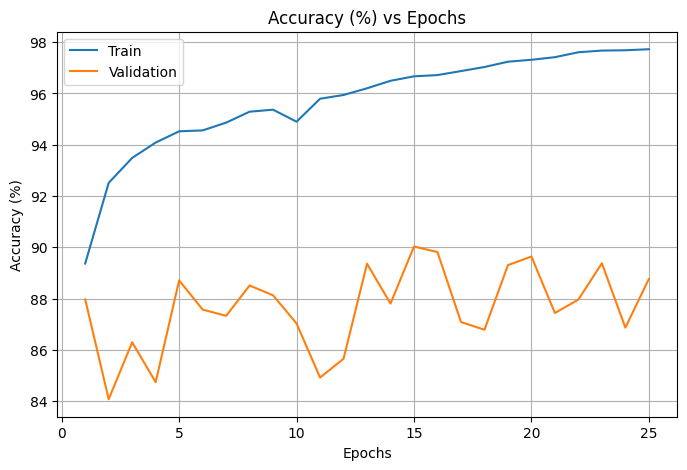

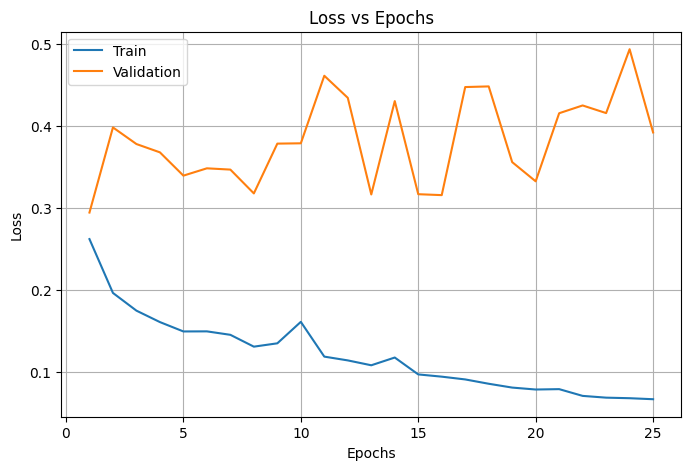

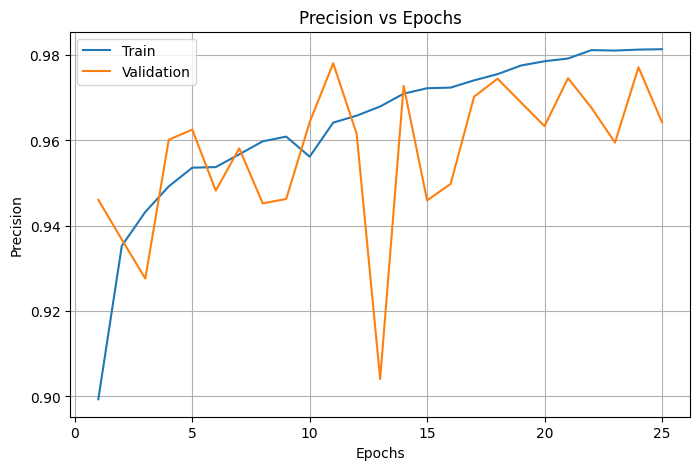

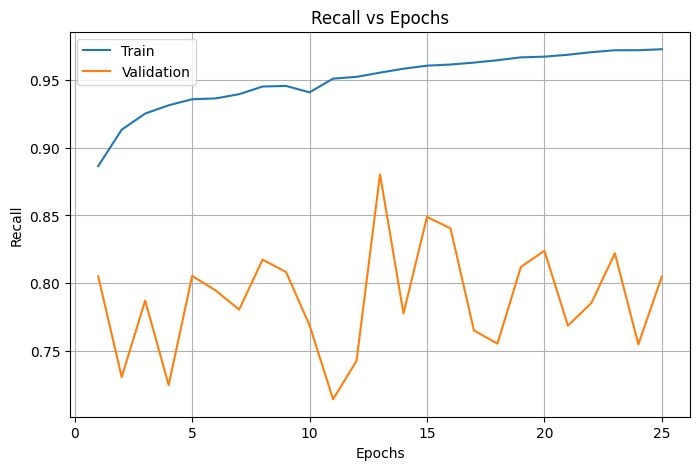

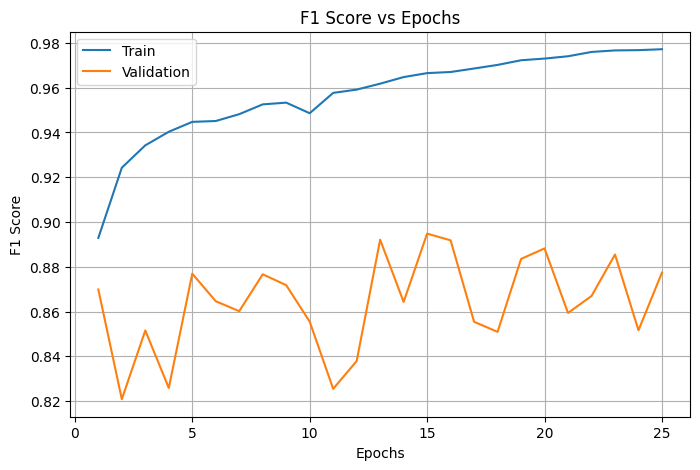

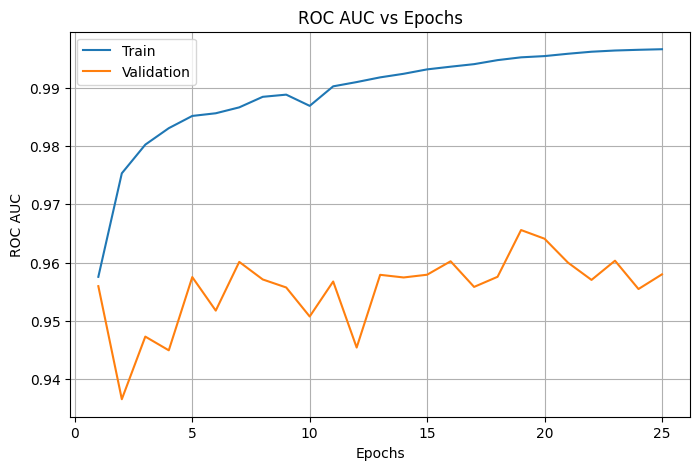

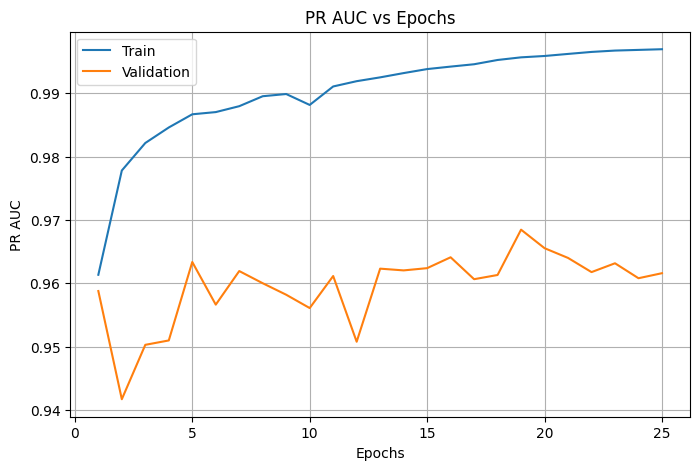

In [10]:
train_metrics = train_model(
    model, train_loader, val_loader, criterion, optimizer, scheduler, epochs
)

with open("metrics.json", "w") as f:
    json.dump(round_metrics(train_metrics), f, indent=4)

epochs_range = range(1, epochs + 1)

metric_names = [
    "accuracies",
    "losses",
    "precisions",
    "recalls",
    "f1s",
    "rocs",
    "prs",
]
metric_labels = [
    "Accuracy (%)",
    "Loss",
    "Precision",
    "Recall",
    "F1 Score",
    "ROC AUC",
    "PR AUC",
]

for metric, label in zip(metric_names, metric_labels):
    plt.figure(figsize=(8, 5))
    plot_metrics(epochs_range, *train_metrics[metric], label, f"{label} vs Epochs")
    plt.savefig(f"{metric}.png", bbox_inches="tight")
    plt.show()
    plt.close()